# ML Analysis
Will attempt to do some sort of clustering.
## Set up Environment

In [73]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# vectorizing the book info column using TFidf Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn import tree

In [74]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/")

In [75]:
os.listdir(path + 'processed')

['processed_books.csv']

## Pull in required data:

In [76]:
df = pd.read_csv(path + 'processed/processed_books.csv')

In [77]:
df.shape

(37141, 21)

In [78]:
df.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings,weighted_ratings_group_encoded
0,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,amy tan,putnam pub group,kitchen god wife,The Kitchen God's Wife by Amy Tan,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,malaysia,65,0,"(4.0, 26.0]",10.0,1,21.0,8.325719,2


### TF-IDF for Book Info:

In [79]:
tf = TfidfVectorizer(analyzer = "word", ngram_range=(1,2), min_df=0, stop_words='english')

In [80]:
tfidf_matrix = tf.fit(df['Book-Info'])

In [81]:
book_vector = tfidf_matrix.transform(df['Book-Info']).toarray()

In [82]:
df['Book-Vector'] = list(book_vector)

## Prepare model:

## Split into train and test set
also want to do cross validation to get mean of models

In [83]:
df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Book-Publisher', 'Book-Author-Processed', 'Book-Publisher-Processed',
       'Book-Title-Processed', 'Book-Info', 'Book-Vector',
       'Year-Of-Publication-Group', 'Year-Of-Publication-Group-Encoded',
       'User-Country', 'User-Country-Encoded', 'Age-Group-Encoded',
       'Age-Group', 'average_rating', 'times_read', 'average_age',
       'weighted_ratings', 'weighted_ratings_group_encoded'],
      dtype='object')

In [84]:
X = df[['Book-Info', 'User-Country-Encoded', 'Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']]
y = df['weighted_ratings_group_encoded']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [86]:
X_train.head(1)

,Book-Info,User-Country-Encoded,Age-Group-Encoded,Year-Of-Publication-Group-Encoded
9148,Song of Solomon (Oprah's Book Club (Paperback)...,7,0,6


## Train Model

In [87]:
%%time
# Define text preprocessing (TF-IDF vectorization) and numeric preprocessing pipelines
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer = "word", ngram_range=(1,2), min_df=0, stop_words='english'))
])


# Define column transformer to apply different preprocessing to specific columns
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'Book-Info'),
    ('group', 'passthrough', ['Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']),
    ('country', 'passthrough', ['User-Country-Encoded'])
])

# Define the full pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

CPU times: user 15 µs, sys: 14 µs, total: 29 µs
Wall time: 42 µs


In [88]:
from sklearn.model_selection import cross_val_score

In [89]:
%%time
scores = cross_val_score(pipeline, X_train, y_train, cv=5)

CPU times: user 19.6 s, sys: 308 ms, total: 19.9 s
Wall time: 20.5 s


In [90]:
print("Cross-validation scores:", scores)

Cross-validation scores: [0.4088844  0.4055191  0.40979468 0.40356782 0.40777516]


In [91]:
# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(min_df=0,
                                                                                   ngram_range=(1,
                                                                                                2),
                                                                                   stop_words='english'))]),
                                                  'Book-Info'),
                                                 ('group', 'passthrough',
                                                  ['Age-Group-Encoded',
                                                   'Year-Of-Publication-Group-Encoded']),
                                                 ('country', 'passthrough',
                                                  ['User-Country-Encoded'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [92]:
y_pred = pipeline.predict(X_test)

## Results

In [93]:
y_pred_train = pipeline.predict(X_train)

accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report (Training Set):")
print(classification_report(y_train, y_pred_train))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix (Training Set):")
print(conf_matrix_train)

Accuracy: 0.9728056004308023
Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8486
           1       0.97      0.97      0.97     11250
           2       1.00      0.95      0.98      9976

    accuracy                           0.97     29712
   macro avg       0.97      0.97      0.97     29712
weighted avg       0.97      0.97      0.97     29712

Confusion Matrix (Training Set):
[[ 8472     9     5]
 [  324 10916    10]
 [  186   274  9516]]


In [94]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix_train)

Accuracy: 0.41755283349037553
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.38      0.33      0.35      2062
           1       0.41      0.50      0.45      2820
           2       0.46      0.40      0.43      2547

    accuracy                           0.42      7429
   macro avg       0.42      0.41      0.41      7429
weighted avg       0.42      0.42      0.42      7429

Confusion Matrix (Test Set):
[[ 681  916  465]
 [ 670 1404  746]
 [ 449 1081 1017]]


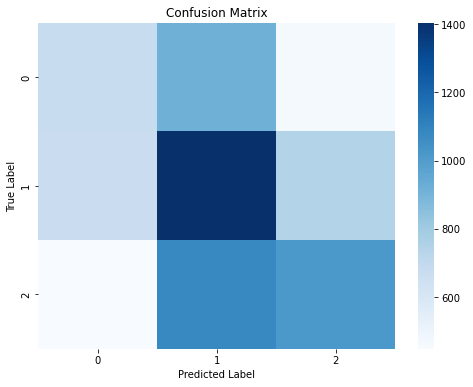

In [97]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, fmt='%d', cmap='Blues',
            xticklabels=['0', '1', '2'],
            yticklabels=['0', '1', '2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [98]:
cm

array([[ 681,  916,  465],
       [ 670, 1404,  746],
       [ 449, 1081, 1017]])

## Able to estimate popularity:

In [99]:
example_dict = {'Book-Info':'harry potter by jk rowling',
                          'User-Country-Encoded':65, 'Age-Group-Encoded':2,
                'Year-Of-Publication-Group-Encoded':7}

X_example = pd.DataFrame(example_dict, index = [0])
X_example

,Book-Info,User-Country-Encoded,Age-Group-Encoded,Year-Of-Publication-Group-Encoded
0,harry potter by jk rowling,65,2,7


In [100]:
# bins for weighted rating: 4.20336529, 7.57571908, 8.05047939, 9.51708247]
# between 8.050 and 9.517
# high populirity
pipeline.predict(X_example)[0]

2

## Dataset info:

In [40]:
df[['Year-Of-Publication-Group', 'Year-Of-Publication-Group-Encoded']].drop_duplicates()

,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded
0,"(1989, 1999]",7
47,"(1999, 2009]",8
172,"(1979, 1989]",6
1588,"(1959, 1969]",4
1600,"(1969, 1979]",5
6028,"(1949, 1959]",3
22704,"(1929, 1939]",1


In [44]:
df[['Age-Group', 'Age-Group-Encoded']].drop_duplicates()

,Age-Group,Age-Group-Encoded
0,"(4.0, 26.0]",0
1,"(26.0, 34.0]",1
2,"(46.0, 100.0]",3
5,"(34.0, 46.0]",2


In [45]:
df[['User-Country', 'User-Country-Encoded']].drop_duplicates()

,User-Country,User-Country-Encoded
0,malaysia,65
1,unknown,121
3,usa,124
7,australia,7
8,brazil,15
...,...,...
27737,urugua,122
31652,croatia,25
33861,u.s.a.,115
34124,tajikistan,107


In [69]:
df['weighted_ratings_group_encoded'].drop_duplicates()

0    3
1    1
3    2
4    0
Name: weighted_ratings_group_encoded, dtype: int64

In [70]:
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings,weighted_ratings_group_encoded
0,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,amy tan,putnam pub group,kitchen god wife,The Kitchen God's Wife by Amy Tan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1989, 1999]",7,malaysia,65,0,"(4.0, 26.0]",10.000000,1,21.0,8.325719,3
1,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,amy tan,putnam pub group,kitchen god wife,The Kitchen God's Wife by Amy Tan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1989, 1999]",7,unknown,121,1,"(26.0, 34.0]",7.000000,1,27.0,7.575719,1
2,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,amy tan,putnam pub group,kitchen god wife,The Kitchen God's Wife by Amy Tan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1989, 1999]",7,unknown,121,3,"(46.0, 100.0]",9.000000,1,72.0,8.075719,3
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,amy tan,putnam pub group,kitchen god wife,The Kitchen God's Wife by Amy Tan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1989, 1999]",7,usa,124,0,"(4.0, 26.0]",8.500000,2,24.0,8.060575,2
4,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,amy tan,putnam pub group,kitchen god wife,The Kitchen God's Wife by Amy Tan,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1989, 1999]",7,usa,124,1,"(26.0, 34.0]",6.333333,3,30.0,7.050479,0
